In [1]:
import math
import tensorflow as tf
import numpy as np
import pylab as plt

C:\Users\lzcai\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
# scale data
def scale(X, X_min, X_max):
    return (X - X_min)/(X_max-X_min)

In [6]:
def process_inputs_from_file(fileName): # Read in data
    inputs = np.loadtxt(fileName, delimiter=' ')
    X, _Y = inputs[:, :NUM_FEATURES], inputs[:, -1].astype(int)
    X = scale(X, np.min(X, axis=0), np.max(X, axis=0))
    _Y[_Y == 7] = 6 # Actually dont have, just in case have error data

    Y = np.zeros((_Y.shape[0], NUM_CLASSES))
    Y[np.arange(_Y.shape[0]), _Y - 1] = 1 #one hot matrix
    return X, Y

In [7]:
def init_weights(feature_no, neuron_no, name, logistic = True):
    # From eg.5.2
    n_in = feature_no
    n_out = neuron_no
    W_values = np.asarray(np.random.uniform(low=-np.sqrt(6. / (n_in + n_out)),
                                            high=np.sqrt(6. / (n_in + n_out)),
                                            size=(n_in, n_out)))
    if logistic == True:
        W_values *= 4
    return(tf.Variable(W_values, dtype=tf.float32, name=name))

def init_bias(neuron_no, name):
    # From eg.5.2
    return(tf.Variable(np.zeros(neuron_no), dtype=tf.float32, name=name))

In [8]:
# Initialize Values
NUM_FEATURES = 36
NUM_CLASSES = 6
NUM_HIDDEN = 10

LEARNING_RATE = 0.01
EPOCHS = 5000
BATCH_SIZE = 32
NUM_NEURONS = 10
SEED = 10
BETA = pow(10, -6)
np.random.seed(SEED)

TRAIN_FILE_NAME = 'sat_train.txt'
TEST_FILE_NAME = 'sat_test.txt'

In [9]:
trainX, trainY = process_inputs_from_file(TRAIN_FILE_NAME)
testX, testY = process_inputs_from_file(TEST_FILE_NAME)

In [10]:
def setup_cross_entropy(labels, logits):
    return tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=logits)

def setup_correct_prediction(labels, logits):
    return tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1)), tf.float32)

In [11]:
x = tf.placeholder(tf.float32, [None, NUM_FEATURES], name='x')
d = tf.placeholder(tf.float32, [None, NUM_CLASSES], name='d')

In [12]:
with tf.variable_scope("Hidden_layer"):
    W = init_weights(NUM_FEATURES, NUM_HIDDEN, name="Weight_1")
    b = init_bias(NUM_HIDDEN, name="Bias_1")
    z = tf.matmul(x, W) + b #syn_input_1
    h = tf.nn.sigmoid(z) #out_1

with tf.variable_scope("Output_layer"):
    V = init_weights(NUM_HIDDEN, NUM_CLASSES, name="Weight_2")
    c = init_bias(NUM_CLASSES, name="Bias_2" )
    y = tf.matmul(h, V) + c #syn_out_2
    f = y #out_2

cross_entropy = setup_cross_entropy(labels=d, logits=y)
regularization = tf.nn.l2_loss(V) + tf.nn.l2_loss(W) 
J = tf.reduce_mean(cross_entropy + BETA * regularization)

optimizer = tf.train.GradientDescentOptimizer(LEARNING_RATE)
train_op = optimizer.minimize(J)

correct_prediction = setup_correct_prediction(labels=d, logits=y)
accuracy = tf.reduce_mean(correct_prediction)

In [10]:
# print(V)

In [11]:
def generate_batch(X_in, y_in, batch_size):
    X = list(X_in)
    y = list(y_in)
    
    if len(X)!=len(y):
        print("Error: len(X)!=len(Y)")
        return None
    batched_X = []
    batched_y = []
    count = 0
    while (len(X) >= batch_size):
        batched_X.append(X[0:batch_size])
        del X[0:batch_size]
        batched_y.append(y[0:batch_size])
        del y[0:batch_size]
        if count % 10 == 0:
            print (count)
        count += 1
    
    if len(X) != 0:
        remain = batch_size-len(X)
        X.extend(batched_X[0][0:remain])
        y.extend(batched_y[0][0:remain])
        batched_X.append(X)
        batched_y.append(y)
        print("Remain rescaled to", len(X))
    
    return (batched_X, batched_y)
        

In [12]:
X, y = generate_batch(trainX, trainY, BATCH_SIZE)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
Remain rescaled to 32


In [13]:
len(X)

139

In [14]:
len(y)

139

In [15]:
trainX[0]

array([0.8125    , 0.8       , 0.76190476, 0.50413223, 0.70967742,
       0.68181818, 0.58947368, 0.390625  , 0.6875    , 0.72815534,
       0.54736842, 0.421875  , 0.98387097, 0.95192308, 0.86956522,
       0.59322034, 0.8125    , 0.82524272, 0.74698795, 0.41463415,
       0.69230769, 0.73786408, 0.6       , 0.416     , 0.96875   ,
       0.95192308, 0.93103448, 0.58333333, 0.75384615, 0.93069307,
       0.82105263, 0.5546875 , 0.6875    , 0.77669903, 0.66315789,
       0.453125  ])

In [16]:
trainY[0]

array([0., 0., 1., 0., 0., 0.])

In [18]:
saver = tf.train.Saver()
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    train_acc = []

    print("********* BEFORE **********")
    print(W.eval())
    print(b.eval())
    print(V.eval())
    print(c.eval())
    print("***************************")
    for i in range(EPOCHS):
    #     for j in range(BATCH_SIZE):
    #         np.random.seed()
    #         rand_index = np.random.choice(a=len(trainX), size=BATCH_SIZE)
    #         x_batch = trainX[rand_index]  # Transpose to the correct shape
    #         y_batch = trainY[rand_index]
    #         train_op.run(feed_dict={x: x_batch, d: y_batch})

    #     train_acc.append(accuracy.eval(feed_dict={x: x_batch, d: y_batch}))


        for j in range(len(X)): # X[j]: One batch with 32 records
            train_op.run(feed_dict={x: X[j], d: y[j]})
        train_acc.append(accuracy.eval(feed_dict={x: X[j], d: y[j]}))

        if i % 100 == 0:
            print('iter %d: accuracy %g'%(i, train_acc[i]))

    print("********* AFTER **********")
    print(W.eval())
    print(b.eval())
    print(V.eval())
    print(c.eval())
    print("**************************")

    save_path = saver.save(sess, "/save/model-PartA-5000-32.ckpt")
    print("Model saved in path: %s" % save_path)

********* BEFORE **********
[[ 0.783916   -1.3846724   0.38614455  0.7188592  -0.00431363 -0.7951342
  -0.872375    0.7527411  -0.956025   -1.1893935 ]
 [ 0.5355528   1.3099715  -1.4332227   0.03522662  0.90324336  0.3251171
   0.64070886 -0.60132426  1.2070583   0.6199653 ]
 [ 0.12292176 -1.0338639  -0.36595154  0.5031174  -0.16805911 -0.19065076
   0.34025946  0.03795981  0.43453664  0.29192784]
 [ 0.8818693   0.06254426  1.180693   -0.522274   -1.1832696  -0.57582945
  -1.1152997   0.94964594 -1.3091346   0.36487648]
 [ 0.1374888   0.9225033  -0.869819    1.0310335  -0.42861417  0.7357435
  -0.5895198   1.1092925  -0.50414234 -0.96785635]
 [-0.310511   -1.1745988   0.92775786 -1.0079126  -0.33482355  1.283585
   1.408877   -0.12624754  0.9422538  -0.71834487]
 [ 0.28133205  1.1638858   0.09984691  0.26061523 -1.331135   -0.4126391
  -1.2146072  -0.562077   -0.48909602  0.7911671 ]
 [-1.3291776  -0.20371546 -0.5347245   0.39435846 -0.4439431  -1.3201108
   1.0976739   0.76057065  1.0

In [19]:
# saver = tf.train.Saver()
# save_path = saver.save(sess, "/model-PartA-5000-32.ckpt")
# print("Model saved in path: %s" % save_path)
# print("********* RESULT **********")
# print(W.eval())
# print(b.eval())
# print(V.eval())
# print(c.eval())
# print("***************************")

In [24]:
del saver

In [15]:
# print("********* RESULT **********")
# print(W.eval())
# print(b.eval())
# print(V.eval())
# print(c.eval())
# print("***************************")
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    output_2_, accuracy_ = sess.run([f, accuracy], feed_dict={x: testX, d: testY})
    print(output_2_, '\n',accuracy_)

InternalError: Blas GEMM launch failed : a.shape=(2000, 36), b.shape=(36, 10), m=2000, n=10, k=36
	 [[Node: Hidden_layer/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_x_0_1/_3, Hidden_layer/Weight_1/read)]]
	 [[Node: Output_layer/add/_7 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_35_Output_layer/add", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'Hidden_layer/MatMul', defined at:
  File "C:\Users\lzcai\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\lzcai\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\lzcai\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\lzcai\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\lzcai\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\Users\lzcai\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\lzcai\Anaconda3\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "C:\Users\lzcai\Anaconda3\lib\asyncio\base_events.py", line 1432, in _run_once
    handle._run()
  File "C:\Users\lzcai\Anaconda3\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\lzcai\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "C:\Users\lzcai\Anaconda3\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\lzcai\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "C:\Users\lzcai\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\lzcai\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\lzcai\Anaconda3\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\lzcai\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\lzcai\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\lzcai\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\lzcai\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\lzcai\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\lzcai\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\lzcai\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\lzcai\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\lzcai\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-8c37576b09b6>", line 4, in <module>
    z = tf.matmul(x, W) + b #syn_input_1
  File "C:\Users\lzcai\Anaconda3\lib\site-packages\tensorflow\python\ops\math_ops.py", line 2018, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "C:\Users\lzcai\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 4750, in mat_mul
    name=name)
  File "C:\Users\lzcai\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\lzcai\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "C:\Users\lzcai\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3155, in create_op
    op_def=op_def)
  File "C:\Users\lzcai\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

InternalError (see above for traceback): Blas GEMM launch failed : a.shape=(2000, 36), b.shape=(36, 10), m=2000, n=10, k=36
	 [[Node: Hidden_layer/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_x_0_1/_3, Hidden_layer/Weight_1/read)]]
	 [[Node: Output_layer/add/_7 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_35_Output_layer/add", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [14]:
saver = tf.train.Saver()
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "/save/model-PartA-5000-32.ckpt")
    print("Model restored.")
    # Check the values of the variables
    print("W : %s" % W.eval())
    print("b : %s" % b.eval())

INFO:tensorflow:Restoring parameters from /save/model-PartA-5000-32.ckpt
Model restored.
W : [[ 0.31106687 -3.8457117   0.47588217  1.0514201  -0.35866028 -0.10578192
  -2.800939    0.4746802  -2.8489954  -2.12224   ]
 [-0.21867697  1.2932494  -0.11584021  0.16695356  3.2356293   1.9050393
  -1.2561027  -1.1009799   0.802198    1.0146898 ]
 [ 0.03579833 -0.86323726 -0.28101853  0.6412965   1.112424    0.45684636
  -2.0990384   0.8139865   3.3221452   0.50667715]
 [ 1.1147425  -0.09018723  0.37485456 -0.34026223 -0.8334732   1.4889703
  -1.8540109   1.5789847   1.1712273   0.4519364 ]
 [-0.4123196  -1.4299246  -0.20056899  1.3521743  -1.7797627   0.20683739
  -0.851116    1.2212508  -1.2524035  -2.1324701 ]
 [ 0.4237336   0.69281495  1.4316111  -0.8957232   1.3725731   2.4378366
   0.8811841  -0.17739858  1.4602513  -0.7911164 ]
 [-0.704818    0.47556037  0.20332262  0.45399383 -1.1294245  -0.26384026
  -1.9279708  -0.17391312  1.4147791   1.141842  ]
 [-1.5505172  -0.86947876 -2.110049

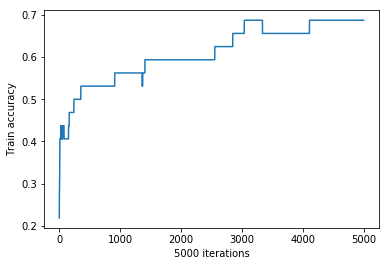

In [23]:
# plot learning curves
plt.figure
(1)
plt.plot(range(EPOCHS), train_acc)
plt.xlabel(str(EPOCHS) + ' iterations')
plt.ylabel('Train accuracy')
plt.savefig("PartA-5000-32-random.png")
plt.show()

In [88]:
for i in range(10):
    np.random.seed()
    rand_index = np.random.choice(int(len(trainX)/BATCH_SIZE), size=BATCH_SIZE)
    print(rand_index)

[109   7  20  43  31  58  24  51 108 125  96  70  23   1 118 113  21 112
  77  52  41  41  22  29  43  54  38 128  45  70  17  59]
[ 32  13  94 116  59   9  12 108 105  47 120  81  99  51  52 117  62  97
  14  36  53  31  75  81   7  12  55  81  65  42  20  41]
[ 39 101   2 127 131  14   9  46  32 114  59  72  72  53 116  51  18  68
  83  65 120 131  12 112 136  10 109 116 127   9  18  38]
[101 113 135  37  31  49 137  52 110  36  74  52  57  94  71 118 110  70
  61 120  50 112  40 128  44 112  51 103 135 111  45   6]
[  9  32 100  90  25  50  97 122  67  77 102  60  67  95  33  34  51 102
  87  95  51  78  47  10  37  70  36  27  15 129  36  76]
[117   0  72  52   6 107  83  20   0  40  47  44  36  89 136 135  49  81
  17  15  93  10  33 111 101  20  21  19  59  94  76  80]
[130  64   1  66 126 125  40  66  48 100  93  67  83 101 130 103  75   1
  25  81  56  64  47 121  75 124  59 137  52   0  12  51]
[ 95 122  14 113   6   4 126 110  78  57  49  17 135  56 104  86  76  84
 109 128 1

array([0.5       , 0.49090909, 0.30952381, 0.2892562 , 0.4516129 ,
       0.41818182, 0.29473684, 0.28125   , 0.375     , 0.40776699,
       0.29473684, 0.28125   , 0.5       , 0.5       , 0.2826087 ,
       0.28813559, 0.484375  , 0.50485437, 0.3253012 , 0.26829268,
       0.49230769, 0.50485437, 0.32222222, 0.272     , 0.484375  ,
       0.5       , 0.27586207, 0.275     , 0.49230769, 0.47524752,
       0.32631579, 0.296875  , 0.421875  , 0.4368932 , 0.32631579,
       0.296875  ])